In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from transformers import ViTFeatureExtractor, ViTModel, ViTConfig, AutoConfig, SwinConfig, SwinModel
from PIL import Image
%matplotlib inline

In [9]:
# Load Training data
df = pd.read_excel('/kaggle/input/csu-cattle-final/CSU_cattle_final/train.xlsx')
df["file_path"] = '/kaggle/input/csu-cattle-final/CSU_cattle_final/train/'+df['label']
df["label"] = df["class"]

In [10]:
# Define function to add data/model in to GPU (cuda)
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
def to_device(data, device):
    # if data is list or tuple, move each of them to device
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device) -> None:
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            # yield only execuate when the function is called
            yield to_device(b, self. device)

    def __len__(self):
        return len(self.dl)

In [11]:
# Define training dataset
class petDataset(Dataset):
    def __init__(self, dataframe, trans_transform=None, res_transform=None):
        self.labels = dataframe["label"]
        self.images = dataframe["file_path"]
        self.trans_transform = trans_transform
        self.res_transform = res_transform

    def __len__ (self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path)

        image_trans = self.trans_transform(np.array(image), return_tensors='pt')
        image_trans = image_trans['pixel_values'].squeeze()

        image_res = self.res_transform(image)

        label = self.labels[idx]

        return image_trans, image_res, label

trans_transform = ViTFeatureExtractor.from_pretrained('google/vit-large-patch16-224')
res_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


train_ds = petDataset(df, trans_transform=trans_transform, res_transform=res_transform)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)

/opt/conda/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [12]:
# Load Training data
df_test = pd.read_excel("/kaggle/input/csu-cattle-final/CSU_cattle_final/test.xlsx")
df_test["file_path"] = '/kaggle/input/csu-cattle-final/CSU_cattle_final/test/'+df_test["label"]# Create image path
df_test["label"] = df_test["class"]

In [13]:
test_ds = petDataset(df_test, trans_transform=trans_transform, res_transform=res_transform)
val_dl = DataLoader(test_ds, batch_size=32, shuffle=False)

In [14]:
# Load pre-trained ResNet50 model
model_Res = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=False)
# Create a new model with the last layer removed
layers_Res = list(model_Res.children())
model_Res = nn.Sequential(*layers_Res[:-1])

# Loop through the named parameters and set requires_grad as needed
for name, param in model_Res.named_parameters():
    if name.startswith('7.') or name.startswith('6.') or name.startswith('5.'):
        param.requires_grad = False
    else:
        param.requires_grad = True
        
from transformers import ViTModel, ViTConfig
import torch
import torch.nn as nn

# Load the pre-trained ViT model
config = ViTConfig()
model_trans = ViTModel(config)
#model_trans = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
# Create a new model with the last two layers removed
layers_trans = list(model_trans.children())
#model_trans_top = nn.Sequential(*layers_trans[:-2])
model_trans_top = nn.Sequential(*layers_trans[:-2])

# Iterate through named parameters and adjust requires_grad attribute
for name, param in model_trans_top.named_parameters():
    if name.startswith("0.") or name.startswith("1.layer.3") or name.startswith("1.layer.4") or name.startswith("1.layer.5") or name.startswith("1.layer.6") or name.startswith("1.layer.7") or name.startswith("1.layer.8") or name.startswith("1.layer.9") or name.startswith("1.layer.6") or name.startswith("1.layer.10") or name.startswith("1.layer.11"):
        param.requires_grad = True
    else:
        param.requires_grad = False

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [15]:


class ModelFinal(nn.Module):
    def __init__(self, model_trans_top, model_Res, dp_rate=0.3):
        super(ModelFinal, self).__init__()
        self.model_trans_top = model_trans_top
        self.trans_flatten = nn.Flatten()
        self.trans_linear = nn.Linear(150528, 64)
        self.res_linear = nn.Linear(2048, 64)

        self.model_Res = model_Res
        self.dropout = nn.Dropout(dp_rate)

        # SE and Ghost Convolution layers for transformer
        #self.se = SELayer(2048)

        # Define self-attention layer
        self.self_attention = nn.MultiheadAttention(embed_dim=64, num_heads=8)
        self.linear2 = nn.Linear(64, 22)

    def forward(self, trans_b, res_b):
        # Transformer path
        result_trans = self.model_trans_top(trans_b)
        patch_state = result_trans.last_hidden_state[:, 1:, :]
        result_trans = self.trans_flatten(patch_state)
        result_trans = self.trans_linear(result_trans)
        result_trans = self.dropout(result_trans)

        # ResNet path
        result_res = self.model_Res(res_b)
        result_res = torch.flatten(result_res, 1)
        result_res=  self.res_linear(result_res)

        # Ensure both results have the same shape for self-attention
        result_res = result_res.unsqueeze(0)
        result_trans = result_trans.unsqueeze(0)

        # Merge the features using self-attention
        #concat_features=torch.cat((result_res, result_trans), dim=0)
        x, _ = self.self_attention(result_trans, result_res, result_trans)
        
        merged_features = x.squeeze(0)

        # Reshape merged_features to a 4D tensor for SE layer
        result = merged_features.unsqueeze(-1).unsqueeze(-1)

        # Apply SE layer
        #result = self.se(merged_features)

        # Flatten the result back to 2D tensor
        result = result.view(result.size(0), -1)

        result = self.linear2(result)
        return result
#model = ModelFinal(model_trans_top, model_Res, dp_rate = 0.3)

In [16]:
model = ModelFinal(model_trans_top, model_Res, dp_rate = 0.3)

In [17]:
model.eval()

ModelFinal(
  (model_trans_top): Sequential(
    (0): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (1): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features

In [18]:
# Add data and model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
train_dl = DeviceDataLoader(train_dl, device)
val_dl=DeviceDataLoader(val_dl, device)
model = to_device(model, device)

In [19]:
# Define optimizer and learning_rate scheduler
params = [param for param in list(model.parameters()) if param.requires_grad]
optimizer = torch.optim.Adam(params, lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.1, 
    patience=2, 
    verbose=True)


In [20]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
patience=20
def fit(epochs, model, train_dl, val_dl):
    device = next(model.parameters()).device  # Get the device the model is on
    opt = optimizer
    sched = lr_scheduler
    loss_func = nn.CrossEntropyLoss()
    
    # Lists to store metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    # Early stopping variables
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        model.train()
        batch_num = 1
        total_train_loss = 0
        total_train_correct = 0
        total_train_samples = 0
        len_train_dl = len(train_dl)  # Number of batches in training dataloader
        
        # Training phase
        for x_trans, x_res, yb in train_dl:
            # Move the data to the same device as the model
            x_trans = x_trans.to(device)
            x_res = x_res.to(device)
            yb = yb.to(device)
            
            # Forward pass
            preds = model(x_trans, x_res)
            loss = loss_func(preds.squeeze(), yb)
            
            # Backward pass and optimization
            loss.backward()
            opt.step()
            opt.zero_grad()
            
            # Calculate training statistics
            total_train_loss += loss.item()
            _, predicted = torch.max(preds.data, 1)
            total_train_correct += (predicted == yb).sum().item()
            total_train_samples += yb.size(0)
            
            print('\r', f'batch #{batch_num}: {loss}', end='')
            batch_num += 1
        
        # Average training loss and accuracy
        avg_train_loss = total_train_loss / len_train_dl
        train_accuracy = 100 * total_train_correct / total_train_samples
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
        sched.step(avg_train_loss)

        # Validation phase
        model.eval()
        total_val_loss = 0
        total_val_correct = 0
        total_val_samples = 0
        len_val_dl = len(val_dl)  # Number of batches in validation dataloader
        
        with torch.no_grad():
            for x_trans, x_res, yb in val_dl:
                # Move the data to the same device as the model
                x_trans = x_trans.to(device)
                x_res = x_res.to(device)
                yb = yb.to(device)
                
                preds = model(x_trans, x_res)
                loss = loss_func(preds.squeeze(), yb)
                
                # Calculate validation statistics
                total_val_loss += loss.item()
                _, predicted = torch.max(preds.data, 1)
                total_val_correct += (predicted == yb).sum().item()
                total_val_samples += yb.size(0)
        
        # Average validation loss and accuracy
        avg_val_loss = total_val_loss / len_val_dl
        val_accuracy = 100 * total_val_correct / total_val_samples
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)
        
        # Print epoch statistics
        print(f'\nEpoch: ({epoch+1}/{epochs}) '
              f'Average Training Loss = {avg_train_loss:.4f}, '
              f'Training Accuracy = {train_accuracy:.2f}%, '
              f'Average Validation Loss = {avg_val_loss:.4f}, '
              f'Validation Accuracy = {val_accuracy:.2f}%')

        # Early stopping logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs.')
                break

    return train_losses, val_losses, train_accuracies, val_accuracies



In [21]:
train_losses, val_losses, train_accuracies, val_accuracies = fit(50, model, train_dl, val_dl)

 batch #5: 3.2479937076568604
Epoch: (1/50) Average Training Loss = 3.3434, Training Accuracy = 4.55%, Average Validation Loss = 3.0015, Validation Accuracy = 6.06%
 batch #5: 3.0340449810028076
Epoch: (2/50) Average Training Loss = 3.0362, Training Accuracy = 7.14%, Average Validation Loss = 3.2176, Validation Accuracy = 15.15%
 batch #5: 2.4911608695983887
Epoch: (3/50) Average Training Loss = 2.8040, Training Accuracy = 14.94%, Average Validation Loss = 2.9451, Validation Accuracy = 22.73%
 batch #5: 2.6286122798919678
Epoch: (4/50) Average Training Loss = 2.5841, Training Accuracy = 23.38%, Average Validation Loss = 2.9844, Validation Accuracy = 15.15%
 batch #5: 2.5355715751647957
Epoch: (5/50) Average Training Loss = 2.3713, Training Accuracy = 30.52%, Average Validation Loss = 2.6748, Validation Accuracy = 36.36%
 batch #5: 1.9452844858169556
Epoch: (6/50) Average Training Loss = 2.2401, Training Accuracy = 40.26%, Average Validation Loss = 2.7274, Validation Accuracy = 39.39%
 

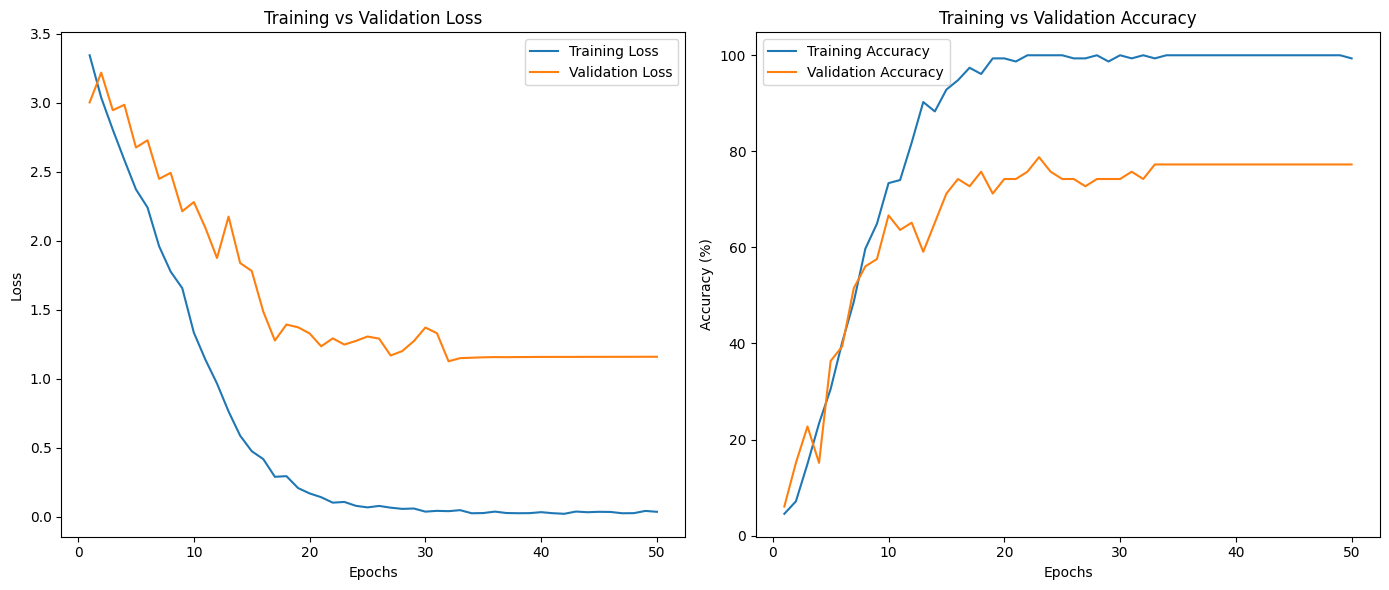

In [1]:
import matplotlib.pyplot as plt

# Data
epochs = list(range(1, 51))  # 1 to 50

# Training and validation loss data
training_loss = [3.3434, 3.0362, 2.8040, 2.5841, 2.3713, 2.2401, 1.9592, 1.7748, 1.6553, 1.3332, 
                 1.1369, 0.9640, 0.7616, 0.5862, 0.4738, 0.4160, 0.2880, 0.2927, 0.2066, 0.1676, 
                 0.1401, 0.1006, 0.1058, 0.0776, 0.0663, 0.0769, 0.0643, 0.0555, 0.0582, 0.0355, 
                 0.0413, 0.0389, 0.0463, 0.0238, 0.0253, 0.0358, 0.0256, 0.0240, 0.0247, 0.0317, 
                 0.0242, 0.0199, 0.0362, 0.0313, 0.0343, 0.0332, 0.0238, 0.0245, 0.0407, 0.0343]
validation_loss = [3.0015, 3.2176, 2.9451, 2.9844, 2.6748, 2.7274, 2.4475, 2.4914, 2.2126, 2.2794, 
                   2.0921, 1.8739, 2.1741, 1.8375, 1.7800, 1.4849, 1.2759, 1.3915, 1.3717, 1.3271, 
                   1.2337, 1.2914, 1.2465, 1.2730, 1.3048, 1.2897, 1.1671, 1.1993, 1.2715, 1.3699, 
                   1.3286, 1.1253, 1.1480, 1.1512, 1.1540, 1.1557, 1.1552, 1.1558, 1.1563, 1.1569, 
                   1.1570, 1.1571, 1.1571, 1.1573, 1.1574, 1.1575, 1.1577, 1.1578, 1.1580, 1.1581]

# Training and validation accuracy data
training_accuracy = [4.55, 7.14, 14.94, 23.38, 30.52, 40.26, 48.70, 59.74, 64.94, 73.38, 
                     74.03, 81.82, 90.26, 88.31, 92.86, 94.81, 97.40, 96.10, 99.35, 99.35, 
                     98.70, 100.00, 100.00, 100.00, 100.00, 99.35, 99.35, 100.00, 98.70, 100.00, 
                     99.35, 100.00, 99.35, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 
                     100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 99.35]
validation_accuracy = [6.06, 15.15, 22.73, 15.15, 36.36, 39.39, 51.52, 56.06, 57.58, 66.67, 
                       63.64, 65.15, 59.09, 65.15, 71.21, 74.24, 72.73, 75.76, 71.21, 74.24, 
                       74.24, 75.76, 78.79, 75.76, 74.24, 74.24, 72.73, 74.24, 74.24, 74.24, 
                       75.76, 74.24, 77.27, 77.27, 77.27, 77.27, 77.27, 77.27, 77.27, 77.27, 
                       77.27, 77.27, 77.27, 77.27, 77.27, 77.27, 77.27, 77.27, 77.27, 77.27]

# Plotting Training and Validation Loss
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, label='Training Accuracy')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
